In [42]:
import numpy as np
import torch
from utility import predict_func_2input, load_best_model
from smalltransformer import SmallTransformer
from linear_process import preprocess_pro
from utility import cal_flux, predict_spectra
from sklearn.metrics import r2_score, mean_squared_error
import pickle
from sklearn.cluster import KMeans

In [43]:
# Model
batch_size = 1
model = SmallTransformer().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# model, optimizer, best_val_loss, target_min, target_max = load_best_model(
#     model, optimizer,
#     '/kaggle/input/noisereduction/pytorch/default/1/best_model_NR_v2.0.pth')
model, optimizer, best_val_loss, target_min, target_max = load_best_model(
    model, optimizer, '/kaggle/best_model_ST_v3.3.pth')

Best model loaded.


In [44]:
# 特征
with open('/kaggle/input/train_preprocessed.pkl', 'rb') as file:
    full_predictions_spectra = pickle.load(file)
full_whitelight_s_train = np.array([
    predict_spectra(full_predictions_spectra[i])
    for i in range(len(full_predictions_spectra))
])  # 预测每个星球的白光缩放比例S
full_light_alpha_train = np.array([
    cal_flux(full_predictions_spectra[i])
    for i in range(len(full_predictions_spectra))
])  # 计算每个星球的各个波段的吸收峰相对面积

In [45]:
# 目标
train_solution = np.loadtxt(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    delimiter=',',
    skiprows=1)
targets = train_solution[:, 1:]
newtarget = targets / full_whitelight_s_train[:, np.newaxis]
targets_tensor = torch.tensor(newtarget).float()
target_min = targets_tensor.min()
target_max = targets_tensor.max()
full_targets_normalized = (targets_tensor - target_min) / (target_max -
                                                           target_min)

In [46]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# # 使用 t-SNE 将数据降维到二维
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(full_targets_normalized)

# # 绘制二维平面上的数据点
# plt.figure(figsize=(10, 8))
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
# plt.title("t-SNE of full_targets_normalized")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.grid(True)
# plt.show()

In [47]:
# 使用 K-means 聚类
n_clusters = 16  # 你可以根据需要调整聚类数量
kmeans = KMeans(n_clusters=n_clusters,
                random_state=42).fit(full_targets_normalized)
cluster_labels = kmeans.labels_

c:\veighna_studio\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [48]:
np.random.seed(21)
# 初始化存储采样的索引列表
sampled_indices = []
samples_per_cluster = 640 // n_clusters  # 每个聚类中目标样本数量

for cluster in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster)[0]

    # 如果样本数量不足，则进行上采样
    if len(cluster_indices) < samples_per_cluster:
        temp_samples = cluster_indices.tolist()
        sampled_indices.extend(temp_samples)
        remaining_samples = samples_per_cluster - len(cluster_indices)
        sampled_indices.extend(
            np.random.choice(cluster_indices, remaining_samples, replace=True))
    else:
        # 样本数量充足时正常采样
        sampled_indices.extend(
            np.random.choice(cluster_indices,
                             samples_per_cluster,
                             replace=False))

print(f"Sampled indices: {len(sampled_indices)}")

Sampled indices: 640


In [49]:
mask = np.ones(full_predictions_spectra.shape[0], dtype=bool)
mask[sampled_indices] = False
predictions_spectra_test = full_predictions_spectra[mask]
min_values = predictions_spectra_test.min(axis=(1, 2), keepdims=True)
max_values = predictions_spectra_test.max(axis=(1, 2), keepdims=True)
normalized_spectra = (predictions_spectra_test - min_values) / (max_values -
                                                                min_values)
data_test_reshaped = torch.tensor(normalized_spectra).float()

In [50]:
predictions_spectra_test.shape

(340, 187, 283)

In [51]:
whitelight_s_test = full_whitelight_s_train[mask]
light_alpha_test = full_light_alpha_train[mask]
whitelight_s_train_expanded = np.expand_dims(full_whitelight_s_train[mask] *
                                             100,
                                             axis=1)
combined_array = np.concatenate(
    (light_alpha_test, whitelight_s_train_expanded), axis=1)
light_alpha_test = torch.tensor(combined_array).float()

In [52]:
all_predictions = predict_func_2input(model,
                                      data_test_reshaped,
                                      light_alpha_test,
                                      batch_size=1)
all_predictions = all_predictions * (target_max - target_min) + target_min
all_predictions = all_predictions.numpy()

In [53]:
all_predictions.min(), all_predictions.max()

(0.91051376, 1.1915591)

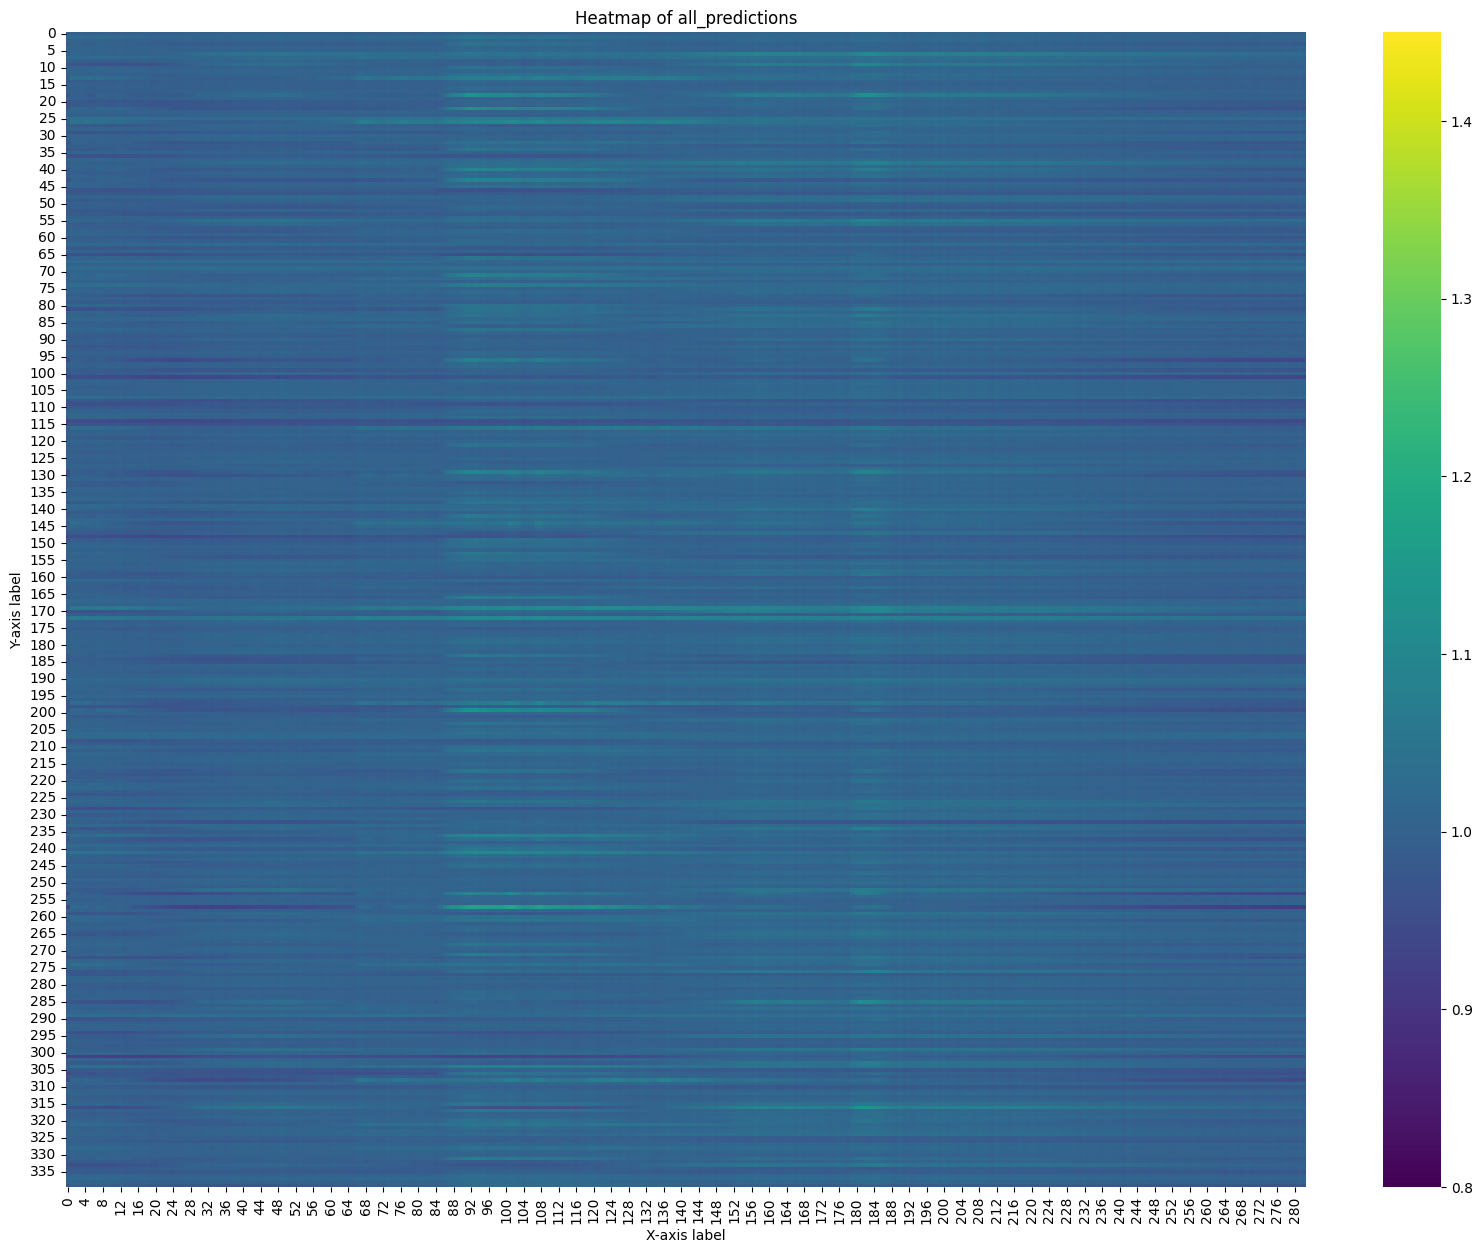

In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(all_predictions,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of all_predictions")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [55]:
from utility import postprocessing, competition_score
import pandas as pd

wavelengths = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/wavelengths.csv')
test_adc_info = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
    index_col='planet_id')
train_labels = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    index_col='planet_id')

In [56]:
reviewtarget = targets[mask] / whitelight_s_test[:, np.newaxis]

In [57]:
reviewtarget.min(), reviewtarget.max()

(0.8628884048867576, 1.1572385936634801)

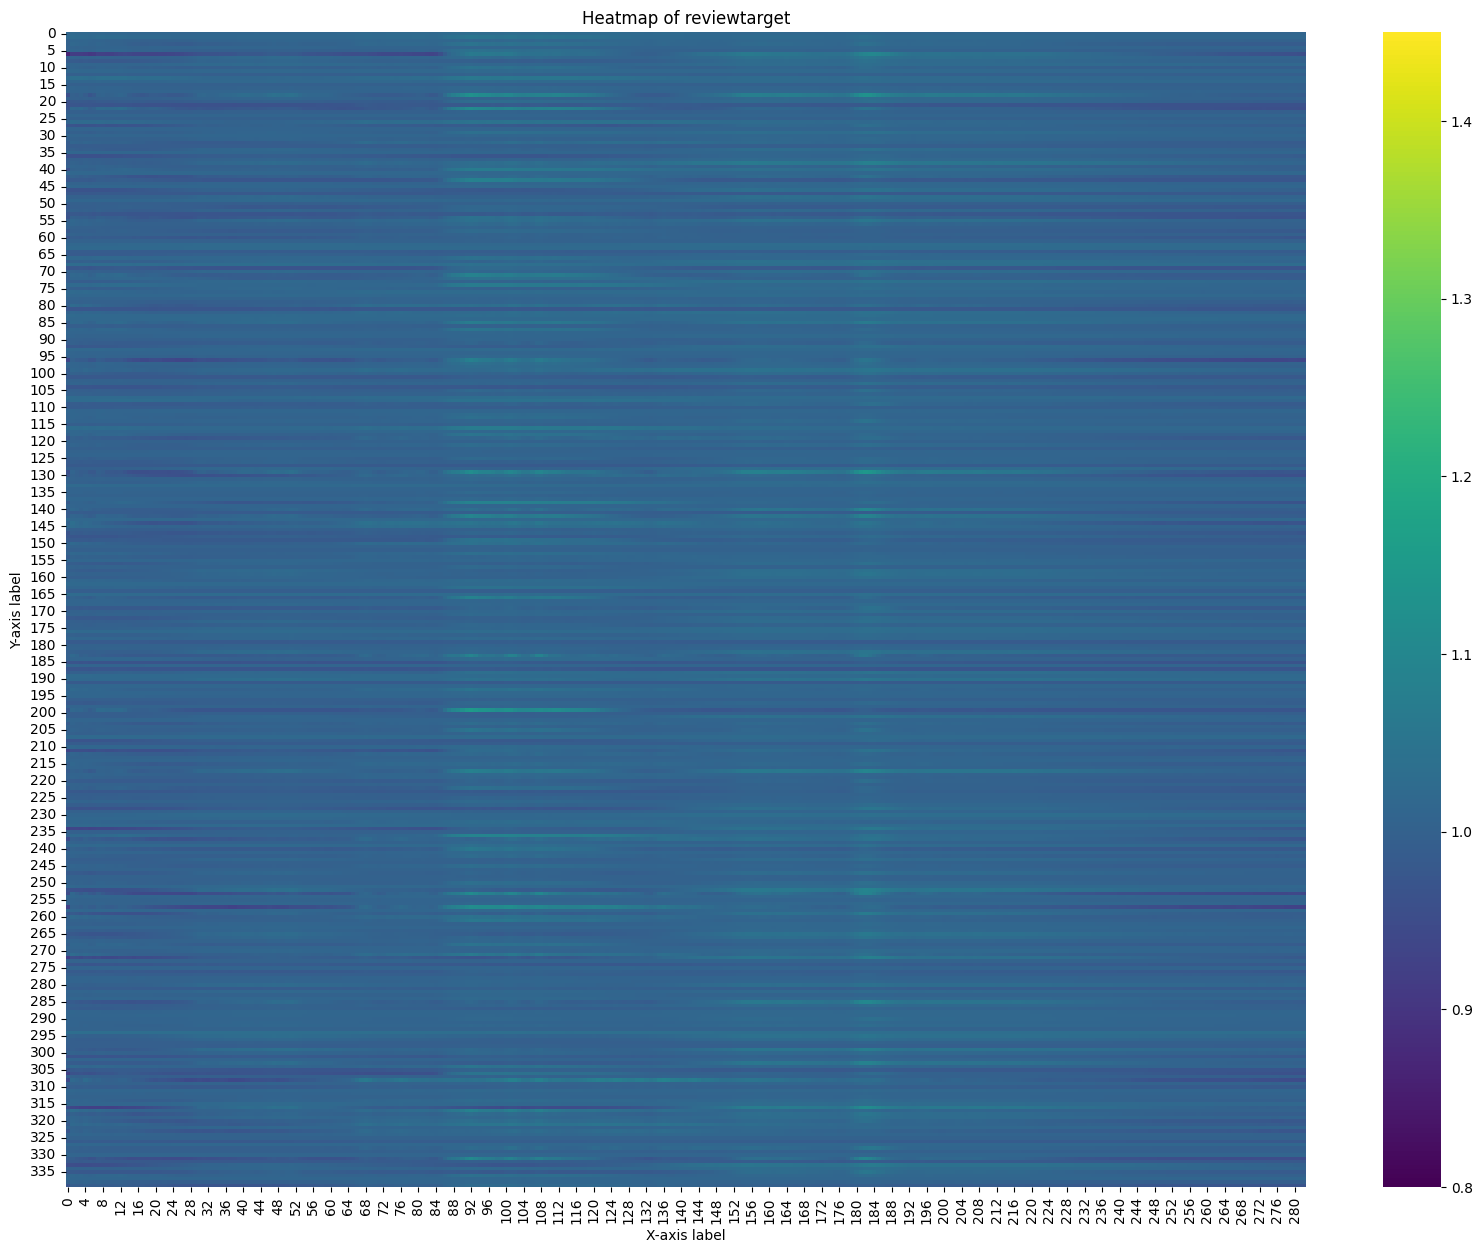

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(reviewtarget,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of reviewtarget")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [59]:
reviewtarget.min(), reviewtarget.max()

(0.8628884048867576, 1.1572385936634801)

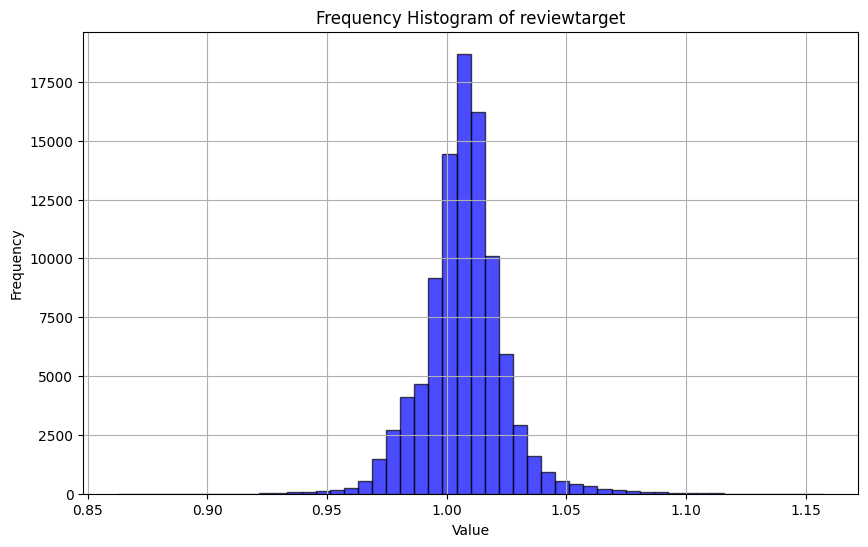

In [60]:
reviewtarget_flat = reviewtarget.flatten()
plt.figure(figsize=(10, 6))
plt.hist(reviewtarget_flat,
         bins=50,
         color='blue',
         edgecolor='black',
         alpha=0.7)
plt.title("Frequency Histogram of reviewtarget")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [61]:
all_predictions = all_predictions * whitelight_s_test[:, np.newaxis]

In [62]:
all_predictions.shape

(340, 283)

In [63]:
targets = targets[mask]

In [64]:
targets.shape

(340, 283)

In [65]:
print(f"# R2 score: {r2_score(targets, all_predictions):.6f}")
sigma_pred = mean_squared_error(targets, all_predictions, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

# R2 score: 0.999553
# Root mean squared error: 0.000037


In [66]:
import numpy as np

# 计算两个数组之间的差值
differences = np.abs(targets - all_predictions)

# 找出差值中的最大值
max_difference = np.max(differences)

# 找出最大值所在的行和列
max_index = np.unravel_index(np.argmax(differences), differences.shape)

print("Max difference:", max_difference)
print("Max difference location (row, column):", max_index)

Max difference: 0.0002950647913306107
Max difference location (row, column): (217, 183)


In [67]:
waveinfo = all_predictions / whitelight_s_test[:, np.newaxis]
avg_waveinfo = np.mean(waveinfo, axis=0)
avg_waveinfo.shape

(283,)

In [68]:
std_size = max_difference / whitelight_s_test[max_index[0]] / avg_waveinfo[
    max_index[1]]

In [69]:
# std_size = sigma_pred / whitelight_s_test[max_index[0]] / avg_waveinfo[
#     max_index[1]]

In [70]:
newsigma = std_size * whitelight_s_test[:, np.newaxis] * avg_waveinfo[
    np.newaxis, :]

In [71]:
newsigma.shape

(340, 283)

In [72]:
newsigma

array([[1.37115773e-04, 1.38636601e-04, 1.38381144e-04, ...,
        1.37406874e-04, 1.38126601e-04, 1.37481266e-04],
       [1.44083543e-04, 1.45681655e-04, 1.45413217e-04, ...,
        1.44389437e-04, 1.45145739e-04, 1.44467610e-04],
       [2.94388310e-04, 2.97653536e-04, 2.97105070e-04, ...,
        2.95013306e-04, 2.96558565e-04, 2.95173027e-04],
       ...,
       [3.23254789e-04, 3.26840189e-04, 3.26237943e-04, ...,
        3.23941069e-04, 3.25637849e-04, 3.24116452e-04],
       [2.81323740e-04, 2.84444060e-04, 2.83919934e-04, ...,
        2.81921000e-04, 2.83397682e-04, 2.82073633e-04],
       [7.73920241e-05, 7.82504224e-05, 7.81062357e-05, ...,
        7.75563299e-05, 7.79625643e-05, 7.75983191e-05]])

In [73]:
sub_df = postprocessing(all_predictions,
                        wavelengths,
                        test_adc_info[mask].index,
                        sigma_pred=newsigma)

In [74]:
# sub_df = postprocessing(all_predictions,
#                         wavelengths,
#                         test_adc_info[mask].index,
#                         sigma_pred=np.tile(
#                             np.where(test_adc_info[mask][['star']] <= 1,
#                                      0.000043, 0.000043), (1, 283)))

In [82]:
gll_score = competition_score(train_labels[mask].copy().reset_index(),
                              sub_df.copy().reset_index(),
                              naive_mean=train_labels.values.mean(),
                              naive_sigma=train_labels.values.std(),
                              sigma_true=0.00001)
print(f"# Estimated competition score: {gll_score:.3f}")

# Estimated competition score: 0.472


In [81]:
best_gll = 0
best_sigma = 0
for i in range(10, 200):
    sigma_test = i * 0.000001
    sub_df = postprocessing(all_predictions,
                            wavelengths,
                            test_adc_info[mask].index,
                            sigma_pred=np.tile(
                                np.where(test_adc_info[mask][['star']] <= 1,
                                         sigma_test, 0.000117), (1, 283)))
    gll_score = competition_score(train_labels[mask].copy().reset_index(),
                                  sub_df.copy().reset_index(),
                                  naive_mean=train_labels.values.mean(),
                                  naive_sigma=train_labels.values.std(),
                                  sigma_true=0.00001)
    if gll_score > best_gll:
        best_gll = gll_score
        best_sigma = sigma_test
print(f"# Best sigma: {best_sigma:.6f}")
print(f"# Best GLL: {best_gll:.3f}")

# Best sigma: 0.000037
# Best GLL: 0.684


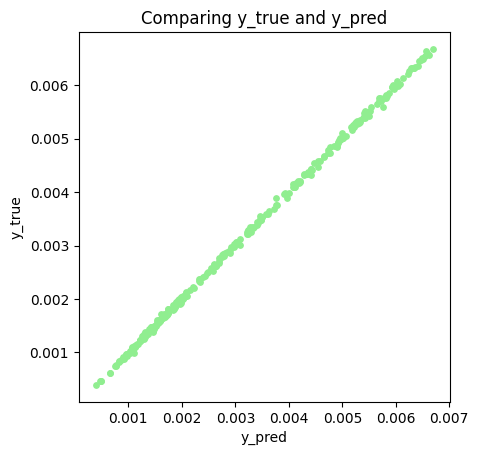

In [77]:
import matplotlib.pyplot as plt

col = 1
plt.scatter(all_predictions[:, col], targets[:, col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

Outlier lens: 6
Outliers: (array([  6,  41, 133, 176, 187, 294], dtype=int64),)


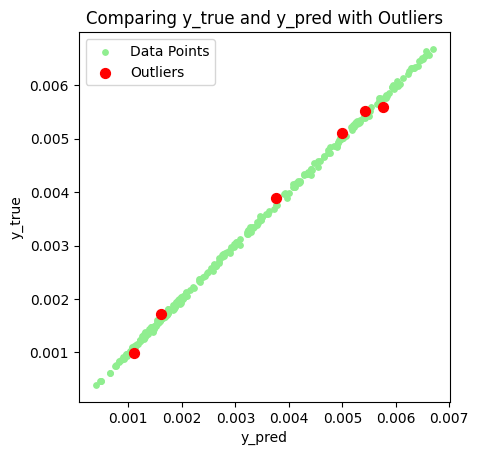

In [78]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

col = 1
# 假设 predict_targets 和 targets 是 numpy 数组
errors = np.abs(all_predictions[:, col] - targets[:, col])
z_scores = np.abs(stats.zscore(errors))

# 设置 Z-score 阈值，通常为 3
threshold = 3
outliers = np.where(z_scores > threshold)

# 打印异常值索引
print("Outlier lens:", len(outliers[0]))
print("Outliers:", outliers)
plt.scatter(all_predictions[:, col],
            targets[:, col],
            s=15,
            c='lightgreen',
            label='Data Points')
plt.scatter(all_predictions[outliers[0], col],
            targets[outliers[0], col],
            s=50,
            c='red',
            label='Outliers')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred with Outliers')
plt.legend()
plt.show()

In [79]:
import numpy as np
from scipy import stats
from collections import Counter, defaultdict

# 假设 predict_targets 和 targets 是 numpy 数组
num_cols = all_predictions.shape[1]
threshold = 3
outlier_counts = Counter()
normal_columns = defaultdict(list)

for col in range(num_cols):
    errors = np.abs(all_predictions[:, col] - targets[:, col])
    z_scores = np.abs(stats.zscore(errors))
    outliers = np.where(z_scores > threshold)[0]
    normals = np.where(z_scores <= threshold)[0]

    # 统计每个异常点的频次
    outlier_counts.update(outliers)

    # 记录每个数据点在哪些列中是正常的
    for normal in normals:
        normal_columns[normal].append(col)

# 按频次排序
sorted_outliers = outlier_counts.most_common()

# 打印每个异常点的频次及其正常的列
for outlier, count in sorted_outliers:
    normal_cols = normal_columns[outlier]
    print(
        f"Data point {outlier} is an outlier in {count} columns and normal in columns: {normal_cols}"
    )

Data point 187 is an outlier in 283 columns and normal in columns: []
Data point 176 is an outlier in 217 columns and normal in columns: [7, 49, 90, 91, 92, 93, 94, 95, 98, 99, 101, 102, 107, 108, 111, 114, 119, 120, 123, 125, 127, 130, 131, 132, 136, 137, 143, 153, 154, 157, 158, 159, 160, 164, 165, 167, 172, 176, 179, 180, 181, 182, 183, 184, 185, 186, 187, 190, 195, 196, 198, 199, 200, 201, 202, 204, 205, 208, 209, 212, 217, 220, 223, 224, 232, 242]
Data point 217 is an outlier in 214 columns and normal in columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 67, 69, 70, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 90, 91, 92, 93, 95, 101, 102, 107, 108, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138]
Data point 104 is an outlier in 169 columns and normal in columns: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 23, 24, 36, 48, 51, 52, 54, 64, 65, 68, 78, 79, 84, 85, 86

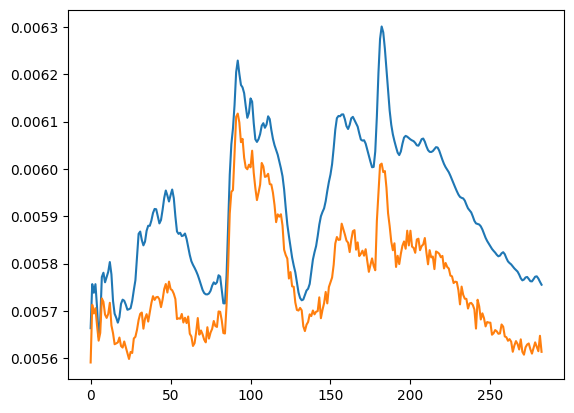

In [80]:
planet = 217
plt.plot(targets[planet, :])
plt.plot(all_predictions[planet, :])